<a href="https://colab.research.google.com/github/OlaKlingberg/DTSA-5511-M4-Disaster-Tweet-Classifier/blob/main/DTSA_5511_M4_Disaster_Tweet_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **About**



# **Imports**

In [ ]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install -q tensorflow-text

In [ ]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
!pip install -q --upgrade keras

In [ ]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import pytz
import json

import seaborn as sns

import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split

from sklearn.utils import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt

from keras_nlp.models import DistilBertPreprocessor
from keras_nlp.models import DistilBertClassifier

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, Callback

from tensorflow.keras.layers import Input

# from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


In [ ]:
print(tf.__version__)
print(keras.__version__)
print(keras_nlp.__version__)

2.17.0
0.1.7
0.17.0


# **Load the data**

In [ ]:

import pandas as pd

# directory = '/content/drive/MyDrive/Colab/Boulder/25. Introduction to Deep Learning/Module 4/data/'
main_dir = '/content/'
data_dir = os.path.join(main_dir, 'data')
results_dir = os.path.join(main_dir, 'results')

results = os.path.join(main_dir, 'results')

df_train = pd.read_csv(os.path.join(data_dir, "train.csv"))
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))



Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


# **Exploratory Data Analysis**

## Take a look at the data sets

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Deal with duplicates

In [ ]:
df_train['target'].unique()

array([1, 0])

In [ ]:
# Display any duplicate rows based on the 'text' column
duplicates = df_train[df_train['text'].duplicated()]

# Print the duplicates
print(duplicates[['text', 'target']].sort_values(by = 'text').head())

# Total number of duplicates
print(f"The training data has {len(duplicates)} tweets that are not unique.")

# Two observations:
# Some duplicates texts have conflicting labels.
# There can be more than 2 of some text.

                                                   text  target
4299  #Allah describes piling up #wealth thinking it...       0
4312  #Allah describes piling up #wealth thinking it...       1
6366  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6373  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
6392  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1
The training data has 110 tweets that are not unique.


In [ ]:
# We went to find duplicates with conflicting labels.
# Find duplicates in 'text' with different 'target' values
conflicting_duplicates = df_train.groupby('text')['target'].nunique().reset_index()
conflicting_duplicates = conflicting_duplicates[conflicting_duplicates['target'] > 1]

# Display the texts with conflicting target values
# print(conflicting_duplicates['text'][:5])

# How many
print(f"There are {len(conflicting_duplicates)} unique texts that have different labels.")

There are 18 unique texts that have different labels.


In [ ]:
# We will remove duplicate texts that have conflicting labels.

# Identify duplicates with conflicting target values
conflicting_texts = df_train.groupby('text')['target'].transform('nunique') > 1

# Filter out rows where the text has conflicting labels
df_cleaned = df_train[~conflicting_texts]

# Reset the index if desired
df_cleaned = df_cleaned.reset_index(drop=True)

print(f"Number of tweets BEFORE removing duplicates with conflicting labesl:", len(df_train))
print(f"Number of tweets AFTER removing duplicates with conflicting labesl:", len(df_cleaned))


Number of tweets BEFORE removing duplicates with conflicting labesl: 7613
Number of tweets AFTER removing duplicates with conflicting labesl: 7558


In [ ]:
# There may still be duplicates that don't have conflicting labels.
# So let's check if we still have duplicates.
# Display any duplicate rows based on the 'text' column
duplicates = df_cleaned[df_cleaned['text'].duplicated()]

# Print the duplicates
print(duplicates[['text', 'target']])

# Total number of duplicates
print(f"There are now {len(duplicates)} tweets that are not unique.")

                                                   text  target
48    Check these out: http://t.co/rOI2NSmEJJ http:/...       0
115   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0
119   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0
164   Experts in France begin examining airplane deb...       1
1152  Japan on Thursday marks the 70th anniversary o...       1
...                                                 ...     ...
7545  Evacuation order lifted for town of Roosevelt:...       1
7552  #stormchase Violent Record Breaking EF-5 El Re...       1
7554  @aria_ahrary @TheTawniest The out of control w...       1
7555  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7556  Police investigating after an e-bike collided ...       1

[73 rows x 2 columns]
There are now 73 tweets that are not unique.


In [ ]:
# Of these remaining dupes (which have non-conflicting labels), we'll keep one of each.
df_unique = df_cleaned.drop_duplicates(subset = 'text', keep = 'first')

print(len(df_train))
print(len(df_unique))

7613
7485


In [ ]:
# We'll finish by assigning df_unique back to df_train
df_train = df_unique.reset_index(drop = True)

In [ ]:
df_train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


## Take a look at a few tweets of each class

In [ ]:
for _, tweet in df_train.head(10).iterrows():
    print(tweet['target'], tweet['text'])
    print()

1 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

1 Forest fire near La Ronge Sask. Canada

1 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

1 13,000 people receive #wildfires evacuation orders in California 

1 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 

1 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires

1 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas

1 I'm on top of the hill and I can see a fire in the woods...

1 There's an emergency evacuation happening now in the building across the street

1 I'm afraid that the tornado is coming to our area...



In [ ]:
# Five non-disaster tweets (class 0)
for _, tweet in df_train[df_train['target'] == 0][['target', 'text']].sample(n = 20, random_state = 42).iterrows():
    print(tweet['target'], tweet['text'])

0 THE LINKS TO WATCH THE SHOW BETTER WORK OR I MIGHT ELECTROCUTE SOMEONE
0 tarmineta3: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.
0 [Question] Is anybody else having this problem with the '7' circle in Epicentre? via /r/jailbreak http://t.co/48TPnmbJVG
0 12' 72W CREE LED Work Light Bar Alloy Spot Flood Combo Diving Offroad 4WD Boat - Full readÛ_ http://t.co/MJMwA72ER6 http://t.co/ADx9iYi246
0 omfg.... I just woke up again....
0 #Cowboys: Wednesday's injury report: RB Lance Dunbar injures ankle is listed as day-to-day:  http://t.co/RkB7EgKveb
0 Why are you drowning in low self-image? Take the quiz: http://t.co/Z8R6r3nBTb http://t.co/nAmffldh5h
0 Also in a matter of weeks Amazon's going to be deluged with poorly written indie dystopian fiction about teens escaping from blood farms.
0 4 Common Running Injuries and How to Avoid Them http://t.co/E5cNS6ufPA
0 @ryanoss123 No worries you'd have to be on every hit

In [ ]:
# Five disaster tweets (class 1)
for _, tweet in df_train[df_train['target'] == 1][['id', 'text', 'target']].sample(n = 20, random_state = 42).iterrows():
    print(tweet['target'], tweet['text'])

1 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/ohNdh2rI0V
1 Don't miss Chris #Appy's detonation of the myths obscuring our crime in #Hiroshima 70 yrs ago this month. @salon http://t.co/DlP8kPkt2k
1 [Comment] Deaths of older children: what do the data tell #US? http://t.co/p8Yr2po6Jn
 #nghlth
1 Sinking ships burning buildings &amp; Falling objects are what reminds me of the old us.
1 For these Californians it's like living in Africa's Sahel desert - just finding water a daily chore. http://t.co/ySG9vsrT4g
1 @xDescry I was wrong to call it trusty actually.. considering it spontaneously collapsed on me that's not very trusty.
1 @flickershowell oh wow my heart collapsed cool im crying cool cool
1 This fire is WAY too close wtf is going on ???? http://t.co/drf3mmRbyx
1 @Erker Again?? Eep! Thought of you yesterday when I saw that hella scary hail. #armageddon?
1 #hot  C-130 specially modified to land in a stadium

This led to two important insights.

First, many tweets are like a single sentence taken out of a conversation: impossible to interpret without a context. This poses a real problem for classifying them. Ideally, for each tweet, we should check if it was part of a thread, or a response to some other tweet, and then use that context when labeling the tweet.

Secondly, even more importantly, the labeling of the tweets seems to be hihgly unreliable. Out of 20 randomly chosen class-1 tweets, 6 (30%) doesn't seem to have any connection to natural disaster:
* @flickershowell oh wow my heart collapsed cool im crying cool cool
* #hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/OnvD9D4NKg #prebreak #best
* You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.
* Islamic State group in Egypt threatens to kill Croat hostage http://t.co/eIoQJWgEiX
* Oops: Bounty hunters try to raid Phoenix police chief's home: A group of armed bounty hunters surrounded the h... http://t.co/dGELJ8rYt9

Another XX (%) are either too hard to make sense of without context, or about things that, while catastrophic, are not really natural disaster. There are two tweets refering to the atomic bombs dropped over Japan. Those were acts of war, not natural disasters:
* 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/ohNdh2rI0V
* Don't miss Chris #Appy's detonation of the myths obscuring our crime in #Hiroshima 70 yrs ago this month. @salon http://t.co/DlP8kPkt2k
* [Comment] Deaths of older children: what do the data tell #US? http://t.co/p8Yr2po6Jn
* Sinking ships burning buildings &amp; Falling objects are what reminds me of the old us.

These tweets are hard to interpret without context:
* @xDescry I was wrong to call it trusty actually.. considering it spontaneously collapsed on me that's not very trusty.
* 2929 @bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM


These tweets seem to refer to catastrophic events, but it's unclear whether those events had anything to do with natural disasters:
* 10770 #science Now that a piece of wreckage from flight MH370 has been confirmed on RÌ©union Island is it possible t...  http://t.co/Z2vDGIyOwf
* 1675 Sioux City Fire Officials Believe Bridge Collapse Lead To Cement Truck Roll Over - Siouxland Matters: Siouxlan... http://t.co/sZTGmbkoHG
* 5187 OSP concerned about mounting fatalities http://t.co/YmP0gInwza http://t.co/FYIOQvIOif
* 1961 dog rendered a kitten from burning buildings

Only XX (%) clearly refer to something that can, if severe enough, be labeled a natural disaster (stormy tidal sea, draught, fire, hail, dust storms), but even in most of these tweets, it's ambiguous:
* For these Californians it's like living in Africa's Sahel desert - just finding water a daily chore. http://t.co/ySG9vsrT4g
* 4678 #RaheelSharif is manifesting how one RIGHT man at the helm can save a Sinking Ship engulfed in a Dark-Stormy-Tidal-Sea. Well Done.
* 5336 This fire is WAY too close wtf is going on ???? http://t.co/drf3mmRbyx
* 478 @Erker Again?? Eep! Thought of you yesterday when I saw that hella scary hail. #armageddon?
* 4333 Raw Video: Dust Storm Rolls Through Texas http://t.co/QllkOfdyzX http://t.co/rGjJuMnNah








## Check the length distribution of tweets

In [ ]:
# Text length distribution in training and testing set.
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7485.000000
mean      100.880428
std        33.826640
min         7.000000
25%        77.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


## Check class distribution

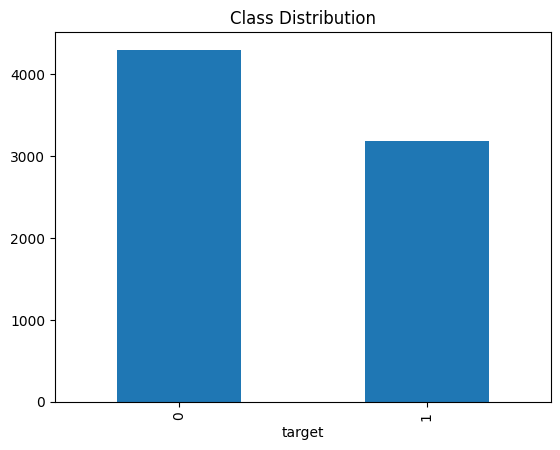

In [ ]:

df_train.target.value_counts().plot(kind = 'bar')
plt.title("Class Distribution")
plt.show()

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes = np.array([0, 1]), y = df_train['target'])

class_weights

array([0.87095648, 1.1739335 ])

# **Configuation**

In [ ]:
# Configs
config = {
    'remove_urls': False,
    'remove_mentions': True,
    'remove_hashtags': False,
    'remove_non_alphas': False,         # Remove all non-alpha characters.
    'model': 'distilbert',                    # 'lstm' or 'distilbert'
    'max_vocab_size': 10000,            # Only for model = 'lstm':
    'max_sequence_length': 100,         # Only for model = 'lstm':
    'embedding_dim': 100,               # Only for model = 'lstm':
    'architecture': 'bidirectional',        # Only for model = 'lstm': 'one_layer', 'two_layer', or 'bidirectional'
    'first_lstm_layer': 32,            # Only for model = 'lstm': Number of units in the first LSTM layer
    'second_lstm_layer': 64,            # Only for model = 'lstm': Number of units in the second LSTM layer
    'dropout': 0.4,                     # Dropout rate to overfitting
    'lr': 0.00001,                        # Learning rate
    'class_0_weight': class_weights[0], # Balanced: class_weights[0]
    'class_1_weight': class_weights[1], # Balanced: class_weights[1]
    'batch': 128,                        # Batch size
    'epochs': 15,                       # Number of epochs
    'patience': 3,                      # Early-stopping patience

}

## Configuration values to explore
I will explore two different models, LSTM and DistilBert. For the LSTM model, I will try three different architectures: with one LSTM layer, with two LSTM layers, and with one bidirectional LSTM layer.

For each of these models, there are a number of hyper-parameter settings to explore. Here is a calculation of the size of the entire configuration space to explore.

**Cleaning**
* Remove Urls: True, False
* Remove Mentions: True, False
* Remove Hashtags: True, False
* Remove all alpha characters: True, False

Cleaning combinations: $2 \times 2 \times 2 \times 2 = 16$

**LSTM model with one layer**
* First LSTM layer, number of units: 32, 64, 128
* Dropout rate: 0.2, 0.3, 0.4, 0.5, 0.6
* Learning rate: 0.01, 0.001, 0.0001
* Class 0 weight: class_weights[0], 0.75, 0.7
* Class 1 weight: Only 1 option for each Class 0 weight
* Batch size: 16, 32, 64, 128

One-layer LSTM combinations: $3 \times 5 \times 3 \times 3 \times 4 = 540$

**LSTM model with two layers**

Same as LSTM model with one layer, plus the options for the second layer:
* Second LSTM layer, number of units: 32, 64, 128.

Two-layer LSTM combinations: $540 \times 3 = 1,620$

**LSTM model with bidirectional layer**

Same as LSTM model with one layer.

Bidirectional LSTM combinations: $540$


**DistilBert model**
* Learning Rate: 0.00001, 0.00003, 0.00005
* Class 0 weight: balanced, 0.75, 0.7 (Determined during early testing.)
* Class 1 weights: Only 1 option for each class_0_weight
* Batch size: 16, 32, 64, 128

DistilBert model combinations: $3 \times 3 \times 4 = 36$

**Total number of settings**

For the for different models (one-layer LSTM, two-laywer LSTM, bidirectional LSTM, DistilBert) we have a total of $540 + 1,620 + 540 + 36 = 2,736$ combinations.

Each of those combinations can be tried with each of the 16 cleaning combinations, for a total configuration space of $2,736 \times 16 = 43,776$ combinations. (And this is even without fine-tuning learning rate to values in between those shown above.)

It should go without saying that I will only be able to explore a tine fraction of these combinations.

**Strategy**

I will follow this strategy:
1. Using an LSTM model with reasonable settings, try the cleaning options one by one, separately, and then combine the most promising ones, and stick with that for the LSTM models.
2. Repeat for a DistilBert model with reasonable settings (since the DistilBert model may benefit from different kinds of cleaning than the LSTM model), and stick with that for the DistilBert model.
3. Explore the LSTM one-layer model by tweaking one parameter at the time.
4. Explore the LSTM two-layer model, using the best parameter settings from the one-layer model as a starting point.
5. Explore the LSTM bidirectional model, using the best parameter settings from the one- and two-layer models as starting point.
6. Explore the DisitilBert model by tweaking one parameter at the time.

I will use the graph of how the metrics change over the course of the epochs as guidance when deciding which parameter to tweak next and how to tweak it. (This will involve a certain amount of guesswork.)

To limit training time, I will use K-fold cross-validation with only 3 folds. This is a compromise between running it with 5 folds, which would yield more stable results but take longer, and not running K-folds cross-validation at all, but just use a dedicated validation set, which would be faster but yield more volatile results.



# **Data cleaning**

In [ ]:
# Remove URLs
if config['remove_urls']:
    df_train['text'] = df_train['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)

In [ ]:
# Remove mentions
if config['remove_mentions']:
    df_train['text'] = df_train['text'].str.replace(r'@\w+', '', regex=True)

In [ ]:
# Remove hashtags
if config['remove_hashtags']:
    df_train['text'] = df_train['text'].str.replace(r'#\w+', '', regex=True)

In [ ]:
# Remove all non-alpha characters
if config['remove_non_alphas']:
    df_train['text'] = df_train['text'].str.replace(r'[^a-zA-Z\s]', '', regex = True).str.lower()

# **GloVe embeddings**

In [ ]:
# Load GloVe embeddings
embedding_index = {}
with open(os.path.join(data_dir, 'glove.6B.100d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors.')

Found 400000 word vectors.


In [ ]:
X_train_df = df_train["text"]
y_train_df = df_train["target"]

X_test_df = df_test["text"]

print(X_train_df.shape)
print(y_train_df.shape)

# Prepare the tweets
# texts = df_train['text']
max_vocab_size = 10000  # Limit vocab size to top 10,000 words
max_sequence_length = 100  # Max length of each tweet (in tokens)

# Tokenize the text data
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(X_train_df)
word_index = tokenizer.word_index

# Convert text to sequences of integers and pad
X_train_sequences = tokenizer.texts_to_sequences(X_train_df)
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_sequence_length)

X_test_sequences = tokenizer.texts_to_sequences(X_test_df)
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_sequence_length)

# Prepare the embedding matrix
embedding_dim = 100  # Using 100-dimensional GloVe vectors
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding_index will be all-zeros
            embedding_matrix[i] = embedding_vector

(7485,)
(7485,)


# **Models**

In [ ]:
def build_lstm_model(config, embedding_matrix):
    model = Sequential()

    # Add the Input layer separately
    model.add(Input(shape=(max_sequence_length,)))

    # Add the embedding layer
    model.add(Embedding(input_dim = max_vocab_size,
                        output_dim = embedding_dim,
                        weights = [embedding_matrix],
                        trainable = False))  # Set trainable=False to use pretrained embeddings

    # Add layers based on selected model architecture
    if config['architecture'] == 'one_layer':
        model.add(LSTM(config['first_lstm_layer'], return_sequences=False))  # Single LSTM layer
    elif config['architecture'] == 'two_layer':
        model.add(LSTM(config['first_lstm_layer'], return_sequences=True))  # First LSTM layer returns full sequence
        model.add(LSTM(config['second_lstm_layer'], return_sequences=False))  # Second LSTM layer
    elif config['architecture'] == 'bidirectional':
        model.add(Bidirectional(LSTM(config['first_lstm_layer'])))  # Bidirectional LSTM
    else:
        raise ValueError("Invalid architecture. Choose from 'one_layer', 'two_layer', or 'bidirectional'.")

    # Add the dropout and activation layers.
    model.add(Dropout(config['dropout'])) # Add a Dropout layer for regularization
    model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

    return model

In [ ]:
def build_distilbert_model(config):
    AUTO = tf.data.experimental.AUTOTUNE

    # Load a DistilBERT model.
    preset= "distil_bert_base_en_uncased"

    # Use a shorter sequence length.
    preprocessor = DistilBertPreprocessor.from_preset(preset,
                                                    sequence_length = 160,
                                                    name = "preprocessor_4_tweets")

    # Pretrained classifier.
    model = DistilBertClassifier.from_preset(preset,
                                                preprocessor = preprocessor,
                                                num_classes = 2)

    return model

In [ ]:
# Custom callback to store metrics at each epoch
class MetricsHistory(Callback):
    def __init__(self, training_data = None, validation_data=None):
        super(MetricsHistory, self).__init__()
        self.training_data = training_data
        self.validation_data = validation_data

        self.epochs = []

        self.accuracy = []
        self.val_accuracy = []
        self.precision = []
        self.val_precision = []
        self.recall = []
        self.val_recall = []
        self.f1 = []
        self.val_f1 = []
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch)

        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

        # Get the predictions on the training data
        y_pred_train = self.model.predict(self.training_data[0])
        y_true_train = self.training_data[1]

        # Convert predictions to binary
        try:
            y_pred_train_binary = (y_pred_train[:, 1] >= 0.5).astype(int) # For DistilBert
        except:
            y_pred_train_binary = (y_pred_train >= 0.5).astype(int) # For LSTM

        # Calculate precision, recall, f1 for training set
        train_precision = precision_score(y_true_train, y_pred_train_binary)
        train_recall = recall_score(y_true_train, y_pred_train_binary)
        train_f1 = f1_score(y_true_train, y_pred_train_binary)

        # Store precision, recall, f1 for training set
        self.precision.append(train_precision)
        self.recall.append(train_recall)
        self.f1.append(train_f1)

        # Get the predictions on the validation data
        y_pred_val = self.model.predict(self.validation_data[0])
        y_true_val = self.validation_data[1]

        try:
            y_pred_val_binary = (y_pred_val[:, 1] >= 0.5).astype(int) # For DistilBert
        except:
            y_pred_val_binary = (y_pred_val >= 0.5).astype(int) # For LSTM

        val_precision = precision_score(y_true_val, y_pred_val_binary)
        val_recall = recall_score(y_true_val, y_pred_val_binary)
        val_f1 = f1_score(y_true_val, y_pred_val_binary)

        self.val_precision.append(val_precision)
        self.val_recall.append(val_recall)
        self.val_f1.append(val_f1)

# **K-fold cross-validation**

In [ ]:
%%time
# Number of folds
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics across all folds
epoch_metrics = {
    # 'epochs': [],
    'accuracy': [],
    'val_accuracy': [],
    'precision': [],
    'val_precision': [],
    'recall': [],
    'val_recall': [],
    'f1': [],
    'val_f1': [],
    'loss': [],
    'val_loss': []
}

# Initialize variables to store cumulative confusion matrix
cumulative_confusion_matrix = np.zeros((2, 2))  # Binary classifier, so 2 x 2 confusion matrix.

# Training loop for K-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train_df)):

    print(f"\nFold {fold + 1}")

    # Clear the previous model to avoid memory issues
    K.clear_session()

    # Create dictionary with class weights
    class_weight_dict = {0: config['class_0_weight'], 1: config['class_1_weight']}

     # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience = config['patience'], restore_best_weights = True)

    # LSTM model
    if config['model'] == 'lstm':

        # Split the data formatted for LSTM into training and validation sets
        X_train, X_val = X_train_padded[train_index], X_train_padded[val_index]
        y_train, y_val = y_train_df[train_index], y_train_df[val_index]

        # Convert to NumPy array. Still needed?
        if isinstance(y_train, pd.Series):
            y_train = y_train.values

        # Build the model
        model = build_lstm_model(config, embedding_matrix)

        # Define the optimizer with a custom learning rate
        optimizer = Adam(learning_rate = config['lr'])

        # Compile
        model.compile(optimizer = optimizer,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

        # Instantiate callback
        metrics_history = MetricsHistory(training_data = (X_train, y_train), validation_data = (X_val, y_val))

        # Train the model
        model.fit(X_train, y_train,
                    epochs=config['epochs'],
                    batch_size=config['batch'],
                    validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,
                    callbacks=[metrics_history, early_stopping])

    # DistilBert model
    elif config['model'] == 'distilbert':
        # Split the data formatted for DistilBert into training and validation sets
        X_train, X_val = X_train_df[train_index], X_train_df[val_index]
        y_train, y_val = y_train_df[train_index], y_train_df[val_index]

        # Build model
        model = build_distilbert_model(config)

        # Compile
        model.compile(
            loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            optimizer = tf.keras.optimizers.Adam(learning_rate = config['lr']),
            metrics= ["accuracy"]
        )

        # Instantiate callback
        metrics_history = MetricsHistory(training_data = (X_train, y_train), validation_data = (X_val, y_val))

        # Fit the model using raw text and labels, with validation data created from train_test_split
        bert_history = model.fit(
            x=X_train,          # Pass raw text data for training
            y=y_train,              # Target labels for training
            batch_size = config['batch'],
            epochs = config['epochs'],
            class_weight=class_weight_dict,
            validation_data=(X_val, y_val),  # Use the validation split from train_test_split
            callbacks=[metrics_history, early_stopping]
        )

    else:
        raise ValueError("Invalid model type. Choose from 'lstm' or 'distilbert'.")

    # Print the model summary only once
        if fold == 0:
            model.summary()

    # Append metrics for this fold to the epoch_metrics dictionary
    epoch_metrics['accuracy'].append(metrics_history.accuracy)
    epoch_metrics['val_accuracy'].append(metrics_history.val_accuracy)
    epoch_metrics['precision'].append(metrics_history.precision)
    epoch_metrics['val_precision'].append(metrics_history.val_precision)
    epoch_metrics['recall'].append(metrics_history.recall)
    epoch_metrics['val_recall'].append(metrics_history.val_recall)
    epoch_metrics['f1'].append(metrics_history.f1)
    epoch_metrics['val_f1'].append(metrics_history.val_f1)
    epoch_metrics['loss'].append(metrics_history.loss)
    epoch_metrics['val_loss'].append(metrics_history.val_loss)

    # Predict on the validation set
    y_pred_val = model.predict(X_val)

    # # Convert predictions to binary
    try:
        y_pred_val_binary = (y_pred_val[:, 1] >= 0.5).astype(int) # For DistilBert
    except:
        y_pred_val_binary = (y_pred_val >= 0.5).astype(int) # For LSTM

    fold_confusion_matrix = confusion_matrix(y_val, y_pred_val_binary)
    cumulative_confusion_matrix += fold_confusion_matrix



Fold 1
Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.6037 - loss: 0.6696 - val_accuracy: 0.7824 - val_loss: 0.5417
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 785ms/step - accuracy: 0.7949 - loss: 0.5071 - val_accuracy: 0.8080 - val_loss: 0.4422
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 777ms/step - accuracy: 0.8284 - loss: 0.4137 - val_accuracy: 0.8192 - val_loss: 0.4203
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 771ms/step - accuracy: 0.8481 - loss: 0.3778 - val_accuracy: 0.8200 - val_loss: 0.4277
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 775ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


39/39 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5815 - loss: 0.6686 - val_accuracy: 0.7731 - val_loss: 0.5232
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 788ms/step - accuracy: 0.8055 - loss: 0.4858 - val_accuracy: 0.7992 - val_loss: 0.4581
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 774ms/step - accuracy: 0.8359 - loss: 0.4088 - val_accuracy: 0.8072 - val_loss: 0.4431
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 769ms/step - accuracy: 0.8463 - loss: 0.3778 - val_accuracy: 0.8092 - val_loss: 0.4479
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 775ms/step - accuracy: 0.8640 - loss: 0.3438 - val_accuracy: 0.8108 - val_loss: 0.4548
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


39/39 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5075 - loss: 0.6760 - val_accuracy: 0.7651 - val_loss: 0.5855
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 785ms/step - accuracy: 0.7892 - loss: 0.5363 - val_accuracy: 0.8020 - val_loss: 0.4549
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 775ms/step - accuracy: 0.8238 - loss: 0.4294 - val_accuracy: 0.8168 - val_loss: 0.4247
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 773ms/step - accuracy: 0.8446 - loss: 0.3832 - val_accuracy: 0.8216 - val_loss: 0.4198
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 773ms/step - accuracy: 0.8637 - loss: 0.3450 - val_accuracy: 0.8220 - val_loss: 0.4259
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 

# **Average metrics across the folds**

In [ ]:
# Due to early stopping, different folds may run different number of epochs.
# We therefore pad the list of epochs with NaN so they are the same length for each fold.
def pad_fold_epoch_lists(metric_list, max_len):
    """Pads each list in metric_list with NaN to ensure equal length."""
    padded_metrics = []
    for seq in metric_list:
        if len(seq) < max_len:
            # Pad the sequence with NaN to make them equal length
            seq = seq + [np.nan] * (max_len - len(seq))
        padded_metrics.append(seq)
    return padded_metrics

# Find the maximum number of epochs across all folds
max_epochs = max(len(acc) for acc in epoch_metrics['accuracy'])

# Pad all metric lists to ensure they have the same length
epoch_metrics['accuracy'] = pad_fold_epoch_lists(epoch_metrics['accuracy'], max_epochs)
epoch_metrics['val_accuracy'] = pad_fold_epoch_lists(epoch_metrics['val_accuracy'], max_epochs)
epoch_metrics['precision'] = pad_fold_epoch_lists(epoch_metrics['precision'], max_epochs)
epoch_metrics['val_precision'] = pad_fold_epoch_lists(epoch_metrics['val_precision'], max_epochs)
epoch_metrics['recall'] = pad_fold_epoch_lists(epoch_metrics['recall'], max_epochs)
epoch_metrics['val_recall'] = pad_fold_epoch_lists(epoch_metrics['val_recall'], max_epochs)
epoch_metrics['f1'] = pad_fold_epoch_lists(epoch_metrics['f1'], max_epochs)
epoch_metrics['val_f1'] = pad_fold_epoch_lists(epoch_metrics['val_f1'], max_epochs)
epoch_metrics['loss'] = pad_fold_epoch_lists(epoch_metrics['loss'], max_epochs)
epoch_metrics['val_loss'] = pad_fold_epoch_lists(epoch_metrics['val_loss'], max_epochs)

# Average the metrics across all folds for each epoch, ignoring NaN values
average_metrics = {
    'accuracy': np.nanmean(epoch_metrics['accuracy'], axis=0),
    'val_accuracy': np.nanmean(epoch_metrics['val_accuracy'], axis=0),
    'precision': np.nanmean(epoch_metrics['precision'], axis=0),
    'val_precision': np.nanmean(epoch_metrics['val_precision'], axis=0),
    'recall': np.nanmean(epoch_metrics['recall'], axis=0),
    'val_recall': np.nanmean(epoch_metrics['val_recall'], axis=0),
    'f1': np.nanmean(epoch_metrics['f1'], axis=0),
    'val_f1': np.nanmean(epoch_metrics['val_f1'], axis=0),
    'loss': np.nanmean(epoch_metrics['loss'], axis=0),
    'val_loss': np.nanmean(epoch_metrics['val_loss'], axis=0)
}

In [ ]:
# Average the confusion matrix over all folds
average_confusion_matrix = cumulative_confusion_matrix / k

# **Generate graphs and save results**

In [ ]:
# Generate a timestamp, to be used in the file names of all generated files
timestamp = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d_%H%M')

In [ ]:
# Create a new dictionary, to hold both configs and final validation results
config_and_results = config.copy()

# Add final validation values to the dictionary
# config_and_results['average_metrics'] = average_metrics
config_and_results['val_acc'] = average_metrics['val_accuracy'][-1]
config_and_results['val_loss'] = average_metrics['val_loss'][-1]
config_and_results['val_precision'] = average_metrics['val_precision'][-1]
config_and_results['val_recall'] = average_metrics['val_recall'][-1]
config_and_results['val_f1'] = average_metrics['val_f1'][-1]

# File name for the config_and_results file
config_and_results_f = f'config_and_results_{timestamp}.json'

# Generate a JSON object with the configs and the results.
with open(os.path.join(results_dir, config_and_results_f), 'w') as f:
    json.dump(config_and_results, f, indent = 4)

## Confusion Matrix

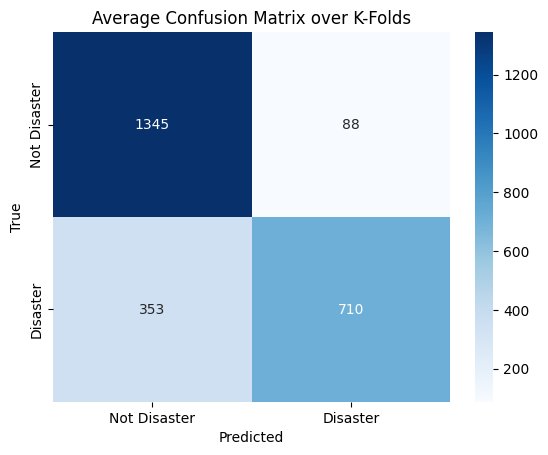

In [ ]:
# Display the averaged confusion matrix
def plot_confusion_matrix(cm, title="Confusion Matrix"):

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", ax=ax)  # Add fmt=".1f" to format floats
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Not Disaster', 'Disaster'])
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(['Not Disaster', 'Disaster'])

    # Save the plot
    conf_matrix_f = f'conf_matrix_{timestamp}.png'
    plt.savefig(os.path.join(results_dir, conf_matrix_f))

    plt.show()

# Show and save the confusion matrix
plot_confusion_matrix(average_confusion_matrix, title="Average Confusion Matrix over K-Folds")

## Metrics across epochs

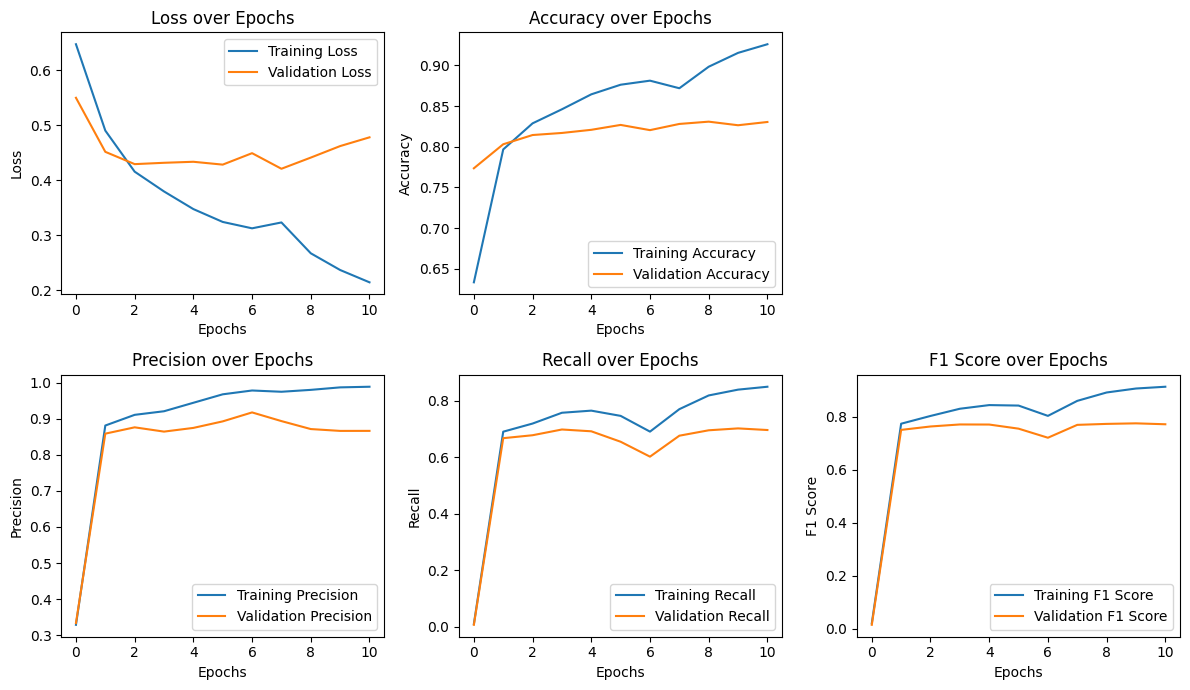

In [ ]:
def plot_all_metrics_over_epochs(average_metrics, timestamp):
    epochs = [*range(len(average_metrics['accuracy']))]

    plt.figure(figsize=(12, 7))

    # Loss plot
    plt.subplot(2, 3, 1)
    plt.plot(epochs, average_metrics['loss'], label='Training Loss')
    plt.plot(epochs, average_metrics['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 3, 2)
    plt.plot(epochs, average_metrics['accuracy'], label='Training Accuracy')
    plt.plot(epochs, average_metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Precision plot
    plt.subplot(2, 3, 4)
    plt.plot(epochs, average_metrics['precision'], label='Training Precision')
    plt.plot(epochs, average_metrics['val_precision'], label='Validation Precision')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Recall plot
    plt.subplot(2, 3, 5)
    plt.plot(epochs, average_metrics['recall'], label='Training Recall')
    plt.plot(epochs, average_metrics['val_recall'], label='Validation Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # F1 plot
    plt.subplot(2, 3, 6)
    plt.plot(epochs, average_metrics['f1'], label='Training F1 Score')
    plt.plot(epochs, average_metrics['val_f1'], label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    plt.tight_layout()

    # Save the plot with a unique timestamp
    metrics_plots_f = f'metric_plots_{timestamp}.png'

    # Save the plot.
    plt.savefig(os.path.join(results_dir, metrics_plots_f))

    plt.draw()
    plt.show()

# Plot metrics over epochs
plot_all_metrics_over_epochs(average_metrics, timestamp)

In [ ]:
average_metrics

{'accuracy': array([0.63333333, 0.7967268 , 0.8287909 , 0.8460922 , 0.86446226,
        0.87628589, 0.88126254, 0.87194389, 0.89839679, 0.91543084,
        0.92605209]),
 'val_accuracy': array([0.77354709, 0.80307281, 0.81442887, 0.81696729, 0.82084169,
        0.82685371, 0.82044089, 0.8280561 , 0.83086175, 0.82645291,
        0.83046091]),
 'precision': array([0.32850242, 0.88149015, 0.91115446, 0.92111578, 0.94463807,
        0.96810677, 0.97870672, 0.97519197, 0.98044693, 0.98737651,
        0.98913634]),
 'val_precision': array([0.33333333, 0.85893952, 0.87649934, 0.86462637, 0.87489973,
        0.89302687, 0.91786736, 0.89380531, 0.87170264, 0.86658796,
        0.86666667]),
 'recall': array([0.01059685, 0.69076577, 0.71952366, 0.75771746, 0.76519189,
        0.7466741 , 0.69097049, 0.77041531, 0.8189454 , 0.83947737,
        0.84974335]),
 'val_recall': array([0.00762631, 0.66776867, 0.6782047 , 0.69850172, 0.69213735,
        0.65519474, 0.60243739, 0.67655502, 0.69569378, 0.70

# **Gather configs and results from all runs**

To make it easy to see how the hyper-parameter tuning affects the results, we will gather the data from configs_and_results from all runs so far into a single dataframe.

In [ ]:
def gather_all_runs():
    # List to store each run's data
    all_runs_data = []

    # Loop through each file in the base directory
    for file in os.listdir(results_dir):
        json_file_path = os.path.join(results_dir, file)

        # Only proceed if it's a JSON file that starts with "config_and_results"
        if file.startswith("config_and_results") and file.endswith(".json"):
            # Extract the date and time part from the file name
            date_time_part = file.replace("config_and_results_", "").replace(".json", "")

            # Read the JSON file
            with open(json_file_path, 'r') as json_file:
                config_and_results = json.load(json_file)
                config_and_results['date_time'] = date_time_part  # Add the date and time to the data
                all_runs_data.append(config_and_results)

    # Convert the list of dictionaries into a Pandas DataFrame
    all_runs_summary = pd.DataFrame(all_runs_data)

    # Replace NaNs with empty strings, for pretty output
    all_runs_summary = all_runs_summary.fillna("")

    # Put the date_time column first
    all_runs_summary = all_runs_summary[['date_time'] + [col for col in all_runs_summary.columns if col != 'date_time']]

    # Sort dataframe by data_tiem
    all_runs_summary.sort_values(by = 'date_time', inplace = True)

    # File name for the summary file
    all_runs_summary_f = f'all_runs_summary_{timestamp}.csv'

    # Save the dataframe to a CSV file
    all_runs_summary.to_csv(os.path.join(results_dir, all_runs_summary_f), index = False)

    # Print the table
    all_runs_summary

gather_all_runs()

# **Generate Submission File**

In [ ]:
# Test data
X_test = df_test['text']

if config['model'] == 'lstm':
    y_pred_test = model.predict(X_test_padded)
    y_pred_test_binary = (y_pred_test >= 0.5).astype(int)
elif config['model'] == 'distilbert':
    y_pred_test = model.predict(X_test)
    y_pred_test_binary = (y_pred_test[:, 1] >= 0.5).astype(int)

# Get the sample submission file
submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

# Populate the submission file with the results
submission['target'] = y_pred_test_binary

# File name for submission file
submission_f = f'submission_{timestamp}.cvs'

# Save the submission file
submission.to_csv(os.path.join(results_dir, submission_f), index = False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


# **Results and discussion**

![all_runs_summary](https://drive.google.com/file/d/1-BSxyi8JZF0azHG-68FjDT5YrszVEl_d/view?usp=sharing)